## 4. Разработка модели и отбор признаков

Основное предположение модели - конкуренты(Qiwi, lamoda и т.п.) удачно выбирают места для своих постаматов, поскольку являются лидерами рынка

Модель учится на данных о размещенных постаматах конкурентов.

Часть датасета дополнительно разметим на уровне здравого смысла и предположений из которых строится модель.
На итоговом датасете построим модель, способную четко разграничить места, в которых постаматы уже размещены, и места, где их точно быть не может. 

На обученной модели произведем отбор признаков, чтобы найти минимальное достаточное количество признаков для адекватного предсказания


In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)

In [7]:
# точки границ Владивостока

with open('./data/adm.geojson', 'r') as f:
    adm = json.load(f)
    
adm = pd.DataFrame(adm['features']).drop('type', axis = 1)
boundries = np.array(adm.geometry[0]['coordinates']).reshape(-1,2)

In [65]:
poi = pd.read_csv('_poi_generated.csv')

In [11]:
poi.head()

,lat,long,amenity,name,description,operator,brand,brand:wikipedia,density100,density200,density300,density500,nearest_com_100_sum,nearest_com_100_mean,nearest_com_100_std,nearest_com_200_sum,nearest_com_200_mean,nearest_com_200_std,nearest_com_300_sum,nearest_com_300_mean,nearest_com_300_std,nearest_com_500_sum,nearest_com_500_mean,nearest_com_500_std,nearest_facility_dist,nearest_atm_dist,nearest_cafe_dist,nearest_grocery_dist,nearest_pharmacy_dist,nearest_medics_dist,nearest_bank_dist,nearest_fast_food_dist,nearest_post_office_dist,nearest_education_neig_dist,nearest_postamat_dist,nearest_goverment_dist,nearest_sdek_dist,nearest_post_box_dist,nearest_pvz_neig_dist
0,43.096901,131.867301,goverment,Vladivostok customs,Владивостокский таможенный пост,NaN,NaN,NaN,0.0,752.0,1136.0,3917.0,0,NaN,NaN,0,NaN,NaN,1,297.086929,0.000000,11,428.977817,46.754010,590.831870,424.516022,413.131623,297.086929,431.703201,549.292893,421.848583,486.115532,406.088903,442.569397,428.920770,0.000000,401.093760,528.899457,5246.582704
1,43.116883,131.879218,atm,NaN,NaN,МДМ Банк,NaN,NaN,241.0,1272.0,2802.0,5950.0,3,42.763196,38.767019,13,133.045022,56.893372,29,200.558815,74.085939,69,327.785869,127.492440,64.999913,0.000000,124.825896,122.327478,366.655035,586.985003,251.458299,34.432770,531.176220,103.595584,763.359282,654.328587,518.643107,379.691754,3011.299474
2,43.133078,131.898725,culture,Москва,NaN,NaN,NaN,NaN,0.0,2953.0,8037.0,17514.0,9,56.687629,23.022305,16,96.303426,51.149134,17,107.976204,68.135143,32,239.745690,153.786326,67.008812,20.467660,92.429813,43.034967,35.871074,92.652227,78.969459,35.704305,380.897159,674.820858,544.536487,290.517044,563.066658,1234.697212,852.880258
3,43.112159,131.873115,nightclub,Наутилус,NaN,NaN,NaN,NaN,79.0,626.0,2167.0,6315.0,0,NaN,NaN,0,NaN,NaN,1,253.688489,0.000000,16,393.073746,59.301863,375.440219,356.675643,365.827863,253.688489,404.888825,378.767758,418.626114,317.805820,597.687830,732.294336,341.153053,550.835313,1235.540678,704.783298,3723.283828
4,43.112892,131.932432,education,NaN,NaN,NaN,NaN,NaN,1059.0,2300.0,3645.0,10021.0,1,95.344657,0.000000,2,135.831377,40.486720,5,218.606621,73.059944,46,388.172470,81.182159,173.844713,176.318097,390.208630,292.789220,95.344657,150.651769,260.427747,330.572524,290.758378,0.000000,501.270933,377.360009,245.091699,169.098014,242.929746


#### EDA
- выделим таргет: почтоматы и ПВЗ конкурентов
- оценим итоговый датасет, чем заполнить пропуски
- оценка распределений признаков

In [12]:
# В качестве таргета используем известные постаматы и Пункты Выдачи Заказов конкурентов

poi['target'] = poi.amenity.apply(lambda x: 1 if (x == 'postamat' or x == 'pvz') else -1)

In [13]:
data = poi.drop(['lat', 'long', 'amenity', 'name', 'description', 'operator', 'brand', 'brand:wikipedia', 'nearest_postamat_dist', 'nearest_pvz_neig_dist'], axis = 1)

In [14]:
data.isna().sum(axis = 0)

density100                       0
density200                       0
density300                       0
density500                       0
nearest_com_100_sum              0
nearest_com_100_mean           623
nearest_com_100_std            623
nearest_com_200_sum              0
nearest_com_200_mean           278
nearest_com_200_std            278
nearest_com_300_sum              0
nearest_com_300_mean           140
nearest_com_300_std            140
nearest_com_500_sum              0
nearest_com_500_mean            50
nearest_com_500_std             50
nearest_facility_dist            0
nearest_atm_dist                 0
nearest_cafe_dist                0
nearest_grocery_dist             0
nearest_pharmacy_dist            0
nearest_medics_dist              0
nearest_bank_dist                0
nearest_fast_food_dist           0
nearest_post_office_dist         0
nearest_education_neig_dist      0
nearest_goverment_dist           0
nearest_sdek_dist                0
nearest_post_box_dis

In [25]:
# пропуски - в признаках средних и стандартного отклонения, если среднее и std считалось от пустого множества
# по смыслу это вполне можно заполнить нулями

data = data.fillna(0)

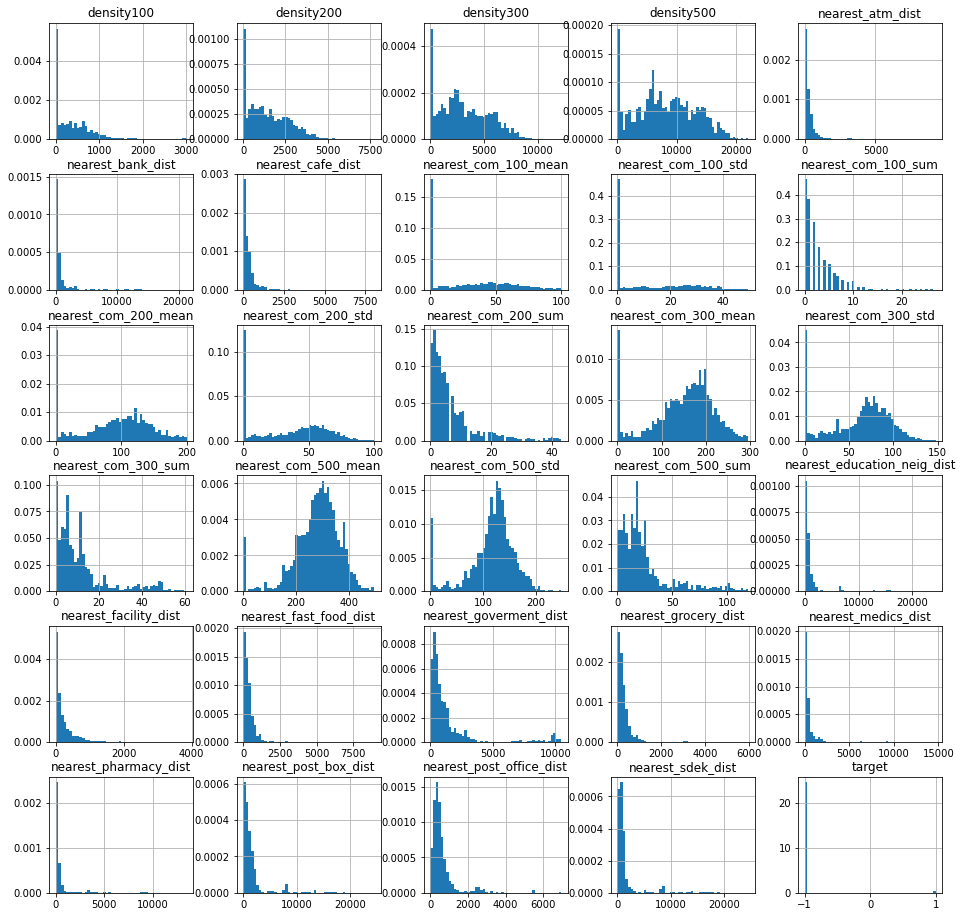

In [29]:
data.hist(figsize = (16, 16), density = True, bins=50);

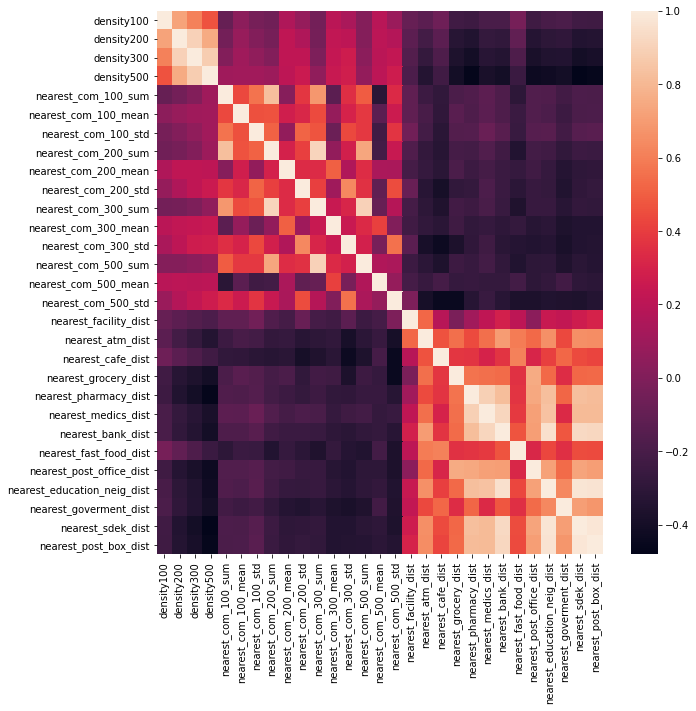

In [11]:
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr())

# План обучения

Имеется частично размеченный датасет. Известен класс только 47ми объектов (класс 1).
Остальные могут быть отнесены к любому классу. 

1. Разметим места, в которых точно нет смысла устанавливать постаматы - это места с минимальной плотностью населения  и/или с минимальным числом коммерческих объектов в окрестности

2. Обучим на разделенном датасете классификатор

3. Определим наиболее значимые признаки

### Разметка класса 0

In [15]:
# допустим объекты у которых в радиусе 200 метров не более 2 коммерческих объектов - класс 0, 
# т.е. места куда постаматы ставить смысла не имеет

class0 = data[(data.nearest_com_200_sum < 3)].index
data.iloc[class0, -1] = 0

In [17]:
#Получилось 846 объектов

data[data.target == 0]

,density100,density200,density300,density500,nearest_com_100_sum,nearest_com_100_mean,nearest_com_100_std,nearest_com_200_sum,nearest_com_200_mean,nearest_com_200_std,nearest_com_300_sum,nearest_com_300_mean,nearest_com_300_std,nearest_com_500_sum,nearest_com_500_mean,nearest_com_500_std,nearest_facility_dist,nearest_atm_dist,nearest_cafe_dist,nearest_grocery_dist,nearest_pharmacy_dist,nearest_medics_dist,nearest_bank_dist,nearest_fast_food_dist,nearest_post_office_dist,nearest_education_neig_dist,nearest_goverment_dist,nearest_sdek_dist,nearest_post_box_dist,target
0,0.0,752.0,1136.0,3917.0,0,NaN,NaN,0,NaN,NaN,1,297.086929,0.000000,11,428.977817,46.754010,590.831870,424.516022,413.131623,297.086929,431.703201,549.292893,421.848583,486.115532,406.088903,442.569397,0.000000,401.093760,528.899457,0
3,79.0,626.0,2167.0,6315.0,0,NaN,NaN,0,NaN,NaN,1,253.688489,0.000000,16,393.073746,59.301863,375.440219,356.675643,365.827863,253.688489,404.888825,378.767758,418.626114,317.805820,597.687830,732.294336,550.835313,1235.540678,704.783298,0
4,1059.0,2300.0,3645.0,10021.0,1,95.344657,0.000000,2,135.831377,40.486720,5,218.606621,73.059944,46,388.172470,81.182159,173.844713,176.318097,390.208630,292.789220,95.344657,150.651769,260.427747,330.572524,290.758378,0.000000,377.360009,245.091699,169.098014,0
6,425.0,2360.0,2984.0,11026.0,0,NaN,NaN,0,NaN,NaN,1,235.652431,0.000000,36,435.354395,54.050931,14.854776,394.758876,413.610969,304.235359,235.652431,287.368154,427.315900,335.079347,89.163343,379.055644,0.000000,330.993466,399.366159,0
12,309.0,1348.0,2387.0,8332.0,1,0.000000,0.000000,2,71.163290,71.163290,7,204.196778,94.646421,10,270.187908,130.990368,160.226935,792.701495,0.000000,257.855286,370.689858,992.896916,1239.925539,142.326580,887.547397,587.807887,1251.458172,1869.877580,2240.780478,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,883.0,2136.0,3845.0,11357.0,0,NaN,NaN,2,181.030256,9.665347,10,258.571628,41.814366,21,322.515875,76.016687,90.011286,268.311606,335.662505,249.227525,190.695603,406.371778,171.364908,260.850888,165.575507,312.012914,567.774055,1137.732691,1894.010840,0
2467,363.0,2148.0,4741.0,14100.0,0,NaN,NaN,2,134.410031,12.932059,3,182.029201,68.166434,21,393.212044,101.799323,121.136882,277.267539,147.342090,520.033425,121.477973,185.189161,334.623119,372.934963,351.613369,946.805766,1555.883603,134.519000,637.359059,0
2468,1262.0,4319.0,6510.0,14777.0,1,11.673083,0.000000,2,67.755084,56.082000,4,144.457426,87.149599,15,340.590190,134.134797,70.609887,435.680362,237.845568,204.473970,11.673083,997.946343,1065.938281,123.837084,917.971848,624.721110,1297.564960,1881.769201,1933.005240,0
2474,900.0,2661.0,6417.0,14645.0,2,28.408481,6.422845,2,28.408481,6.422845,3,113.794294,120.867598,13,319.230831,132.724200,262.483604,359.139009,451.822386,34.831326,21.985636,1007.604235,784.126776,356.231965,736.382106,869.912169,1320.492600,1815.267563,1840.685901,0


In [18]:
train = data[(data.target != -1)] # train - весь размеченный датасет, т.к. 
# выделять тестовый датасет для 47 точек нецелесообразно, данных слишком мало, 
# а кроме того нет финансовых критериев оценки качества (данные не предоставлены)
# будем учить модель на всем размеченном датасете, а качество оценки определять визуально, 
# отрисовав на карте предсказания о остальным - оценка вероятности должна быть выше
# по мере приближения к действующим постаматам - это мы и должны увидеть.
# Так же хочется увидеть новые точки роста вероятности, в которых постаматов нет

test = data[(data.target == -1)]

In [19]:
train.corrwith(data['target'])

density100                     0.013420
density200                     0.068354
density300                     0.110229
density500                     0.126273
nearest_com_100_sum            0.595710
nearest_com_100_mean           0.189829
nearest_com_100_std            0.373895
nearest_com_200_sum            0.683971
nearest_com_200_mean           0.004622
nearest_com_200_std            0.293870
nearest_com_300_sum            0.485314
nearest_com_300_mean          -0.089392
nearest_com_300_std            0.168489
nearest_com_500_sum            0.215114
nearest_com_500_mean          -0.166112
nearest_com_500_std            0.195072
nearest_facility_dist          0.000365
nearest_atm_dist              -0.111206
nearest_cafe_dist             -0.095368
nearest_grocery_dist          -0.129539
nearest_pharmacy_dist         -0.093205
nearest_medics_dist           -0.078100
nearest_bank_dist             -0.099586
nearest_fast_food_dist        -0.095260
nearest_post_office_dist      -0.108346


###  Метрика - ROC AUC


In [20]:
from sklearn.metrics import roc_auc_score

### Обучим модель
используем градиентный бустинг

In [21]:
import catboost
from catboost import cv, Pool

In [39]:
# Отбросим признак nearest_com_200_sum, т.к. по нему был доразмечен train датасет, 
# а значит он будет черезчур коррелировать с таргетом, что не даст модели найти зависимости

X = train.drop(['target', 'nearest_com_200_sum'], axis = 1)
y = train.target

In [26]:
# Используем встроенную кросс-валидацию catboost для оценки модели на размеченном датасете

params = {}
params['n_estimators'] = 200
params['loss_function'] = 'CrossEntropy'
params['eval_metric'] = 'AUC'
params['random_seed'] = 0

cv_scores = cv(
    params = params,
    pool = Pool(X, y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified = True,
    verbose=1)

best_value = np.max(cv_scores['test-AUC-mean'])
best_iter = np.argmax(cv_scores['test-AUC-mean'])
std = cv_scores['test-AUC-std'][best_iter]

0:	test: 0.8802157	best: 0.8802157 (0)	total: 1.13s	remaining: 3m 44s
1:	test: 0.9658396	best: 0.9658396 (1)	total: 2.06s	remaining: 3m 24s
2:	test: 0.9662340	best: 0.9662340 (2)	total: 3.07s	remaining: 3m 21s
3:	test: 0.9784285	best: 0.9784285 (3)	total: 3.99s	remaining: 3m 15s
4:	test: 0.9791038	best: 0.9791038 (4)	total: 5.07s	remaining: 3m 17s
5:	test: 0.9761161	best: 0.9791038 (4)	total: 5.9s	remaining: 3m 10s
6:	test: 0.9770389	best: 0.9791038 (4)	total: 6.94s	remaining: 3m 11s
7:	test: 0.9745609	best: 0.9791038 (4)	total: 7.94s	remaining: 3m 10s
8:	test: 0.9753622	best: 0.9791038 (4)	total: 8.9s	remaining: 3m 8s
9:	test: 0.9753799	best: 0.9791038 (4)	total: 9.87s	remaining: 3m 7s
10:	test: 0.9727435	best: 0.9791038 (4)	total: 10.8s	remaining: 3m 5s
11:	test: 0.9822587	best: 0.9822587 (11)	total: 11.8s	remaining: 3m 4s
12:	test: 0.9815173	best: 0.9822587 (11)	total: 12.9s	remaining: 3m 5s
13:	test: 0.9810753	best: 0.9822587 (11)	total: 13.9s	remaining: 3m 4s
14:	test: 0.9799966	b

114:	test: 0.9969789	best: 0.9969789 (109)	total: 1m 55s	remaining: 1m 25s
115:	test: 0.9971260	best: 0.9971260 (115)	total: 1m 56s	remaining: 1m 24s
116:	test: 0.9971260	best: 0.9971260 (115)	total: 1m 57s	remaining: 1m 23s
117:	test: 0.9971260	best: 0.9971260 (115)	total: 1m 58s	remaining: 1m 22s
118:	test: 0.9971260	best: 0.9971260 (115)	total: 1m 59s	remaining: 1m 21s
119:	test: 0.9969569	best: 0.9971260 (115)	total: 2m	remaining: 1m 20s
120:	test: 0.9971260	best: 0.9971260 (115)	total: 2m 1s	remaining: 1m 19s
121:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 2s	remaining: 1m 18s
122:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 3s	remaining: 1m 17s
123:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 4s	remaining: 1m 16s
124:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 5s	remaining: 1m 15s
125:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 6s	remaining: 1m 14s
126:	test: 0.9969569	best: 0.9971260 (115)	total: 2m 7s	remaining: 1m 13s
127:	test: 0.9971260	best: 0.9971260

In [27]:
# видим, что задача хорошо решается в рамках поставленных условий, без каких либо дополнительных настроек

print(best_value)

0.9971259509721048


In [40]:
cat_model = catboost.CatBoostClassifier(     random_state=0, 
                                             auto_class_weights = 'Balanced',
                                             eval_metric = 'AUC',
                                             verbose = 0)

cat_model.fit(X, y)

In [41]:
roc_auc_score(cat_model.predict(X), y)

1.0

In [42]:
# оценим важность признаков, чтобы отобрать наиболее значимые радиусы для статистик и категории объектов

cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,nearest_com_100_sum,13.289078
1,nearest_com_100_std,9.311462
2,nearest_com_200_std,8.726632
3,nearest_pharmacy_dist,6.741233
4,nearest_com_300_sum,5.876189
5,nearest_atm_dist,5.390805
6,nearest_com_500_mean,5.355934
7,nearest_grocery_dist,4.507679
8,nearest_bank_dist,3.925711
9,nearest_facility_dist,3.697011


In [43]:
# оставим наиболее важные признаки среди плоности населения, статистик расстояния разного радиуса 
# и ближайших объетов инфраструктуры

base_features = ['density500',            # численность населения в радиусе 500 метров
                 'nearest_com_100_sum',   # число коммерческих объектов в радиусе 100 метров
                 'nearest_com_100_std',   # стд. отклонение расстояний до комм. объектов - 100м
                 'nearest_com_100_mean',  # среднее расстояний до комм. объектов - 100м
                 'nearest_pharmacy_dist', # расст. до ближайшей аптеки
                 'nearest_atm_dist',      # расст. до ближайшего банкомата
                 'nearest_grocery_dist',  # расст. до ближайшего магазина
                 'nearest_bank_dist']     # расст. до ближайшего банка

In [44]:
X = train[base_features]
y = train.target

In [45]:
# Используем встроенную кросс-валидацию catboost для оценки модели на размеченном датасете

params = {}
params['n_estimators'] = 200
params['loss_function'] = 'CrossEntropy'
params['eval_metric'] = 'AUC'
params['random_seed'] = 0

cv_scores = cv(
    params = params,
    pool = Pool(X, y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified = True,
    verbose=1)

best_value = np.max(cv_scores['test-AUC-mean'])
best_iter = np.argmax(cv_scores['test-AUC-mean'])
std = cv_scores['test-AUC-std'][best_iter]

0:	test: 0.9449170	best: 0.9449170 (0)	total: 961ms	remaining: 3m 11s
1:	test: 0.9730513	best: 0.9730513 (1)	total: 1.86s	remaining: 3m 4s
2:	test: 0.9757884	best: 0.9757884 (2)	total: 2.73s	remaining: 2m 59s
3:	test: 0.9809783	best: 0.9809783 (3)	total: 3.59s	remaining: 2m 55s
4:	test: 0.9830415	best: 0.9830415 (4)	total: 4.43s	remaining: 2m 52s
5:	test: 0.9812918	best: 0.9830415 (4)	total: 5.31s	remaining: 2m 51s
6:	test: 0.9798681	best: 0.9830415 (4)	total: 6.21s	remaining: 2m 51s
7:	test: 0.9839363	best: 0.9839363 (7)	total: 7.09s	remaining: 2m 50s
8:	test: 0.9847992	best: 0.9847992 (8)	total: 8.01s	remaining: 2m 49s
9:	test: 0.9863596	best: 0.9863596 (9)	total: 9.04s	remaining: 2m 51s
10:	test: 0.9838448	best: 0.9863596 (9)	total: 9.97s	remaining: 2m 51s
11:	test: 0.9834010	best: 0.9863596 (9)	total: 10.9s	remaining: 2m 50s
12:	test: 0.9819834	best: 0.9863596 (9)	total: 11.7s	remaining: 2m 48s
13:	test: 0.9803605	best: 0.9863596 (9)	total: 12.6s	remaining: 2m 47s
14:	test: 0.97987

114:	test: 0.9902384	best: 0.9907025 (109)	total: 1m 43s	remaining: 1m 16s
115:	test: 0.9902384	best: 0.9907025 (109)	total: 1m 44s	remaining: 1m 15s
116:	test: 0.9904075	best: 0.9907025 (109)	total: 1m 44s	remaining: 1m 14s
117:	test: 0.9905766	best: 0.9907025 (109)	total: 1m 45s	remaining: 1m 13s
118:	test: 0.9905766	best: 0.9907025 (109)	total: 1m 46s	remaining: 1m 12s
119:	test: 0.9905766	best: 0.9907025 (109)	total: 1m 47s	remaining: 1m 11s
120:	test: 0.9904075	best: 0.9907025 (109)	total: 1m 48s	remaining: 1m 10s
121:	test: 0.9909147	best: 0.9909147 (121)	total: 1m 49s	remaining: 1m 9s
122:	test: 0.9909147	best: 0.9909147 (121)	total: 1m 50s	remaining: 1m 9s
123:	test: 0.9909147	best: 0.9909147 (121)	total: 1m 51s	remaining: 1m 8s
124:	test: 0.9909147	best: 0.9909147 (121)	total: 1m 52s	remaining: 1m 7s
125:	test: 0.9907456	best: 0.9909147 (121)	total: 1m 52s	remaining: 1m 6s
126:	test: 0.9908935	best: 0.9909147 (121)	total: 1m 53s	remaining: 1m 5s
127:	test: 0.9908935	best: 0.99

In [46]:
# Обучим итоговую модель

cat_model = catboost.CatBoostClassifier(     random_state=0, 
                                             auto_class_weights = 'Balanced',
                                             eval_metric = 'AUC',
                                             verbose = 0)

cat_model.fit(X, y)
roc_auc_score(cat_model.predict(X), y)

1.0

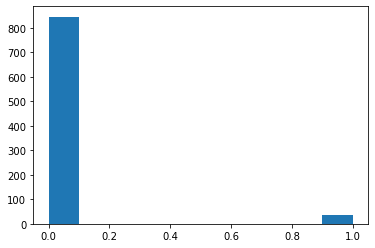

In [48]:
# посмотрим предсказания вероятностей
# видно, что вероятности стремятся к крайним значениям
# с одной стороны это плохо, с другой - модель изначально обучена на крайних значениях
# возможно, это не помешает регулировать пограничные случая через порор вероятности

plt.hist(cat_model.predict_proba(X)[:,1]);

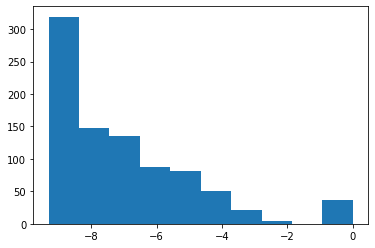

In [52]:
# в логарифмической шкале вероятности уже не так экстремально стремятся к крайним значениям
# а значит возможно регулировать число предсказанных мест через порог

plt.hist(np.log(cat_model.predict_proba(X)[:,1]));

In [53]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,nearest_pharmacy_dist,21.982510
1,nearest_bank_dist,15.441972
2,nearest_atm_dist,13.433207
3,nearest_grocery_dist,12.744157
4,nearest_com_100_sum,12.571967
5,nearest_com_100_std,9.459922
6,density500,7.977327
7,nearest_com_100_mean,6.388939


## 5. Прогнозирование и визуализация

- Для датасета всех строений города сгенерируем признаки, которые были отобраны на этапе обучения.
- И дадим прогноз вероятности размещения постамата для любой точки города.
- Отразим предсказания на карте

#### Признаки для строений города сгенерируем так же, как для POI

In [59]:
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

bui = pd.read_csv('_buildings_density.csv')

In [61]:
# функция расстояния от географичеcких координат

def dist(x, y):
    l1, l2 = np.radians(x[1]), np.radians(y[1])
    s1, s2 = np.radians(x[0]), np.radians(y[0])
    dl = np.abs(l1-l2)
    return np.arccos(np.sin(s1)*np.sin(s2)+np.cos(s1)*np.cos(s2)*np.cos(dl)) * 6372000

In [62]:
amenities = 'atm cafe grocery pharmacy bank fast_food'.split()

# подвыборка коммерческих объектов Points of Interest
commersial = poi[poi.amenity.isin(amenities)]

In [63]:
# %%time
# # commersial_neig - соседи изучаемых коммерческих категорий
# commersial_neig = NearestNeighbors(algorithm = 'ball_tree', metric = dist).fit(commersial[['lat', 'long']])

CPU times: user 837 ms, sys: 0 ns, total: 837 ms
Wall time: 875 ms


In [ ]:
# # Генерируем метрические признаки для коммерческих объектов в разных радиусах

# nearest_commerc_features = {}
# nearest_commerc_features[100] = {'sum':[], 'mean': [], 'std':[]}
# commerc_radius = [100]

# for radius in tqdm(nearest_commerc_features):
#     for i in tqdm(range(len(bui))):
#         point = bui[['lat','long']].iloc[i]
#         rng = commersial_neig.radius_neighbors(point.values.reshape(-1,2), radius = radius)

#         # кол-во коммерческих объектов в радиусе
#         nearest_commerc_features[radius]['sum'].append(len(rng[0][0]))
        
#         # mean расстояний до коммерческих объектов в радиусе
#         nearest_commerc_features[radius]['mean'].append(np.mean(rng[0][0]))
        
#         # mean расстояний до коммерческих объектов в радиусе
#         nearest_commerc_features[radius]['std'].append(np.std(rng[0][0]))

In [ ]:
# bui['nearest_com_100_sum'] = nearest_commerc_features[100]['sum']
# bui['nearest_com_100_mean'] = nearest_commerc_features[100]['mean']
# bui['nearest_com_100_std'] = nearest_commerc_features[100]['std']

In [64]:
# %%time
# # модели ближайших соседей до отдельным изучаемым категориям

# ds = poi
# atm_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'atm'][['lat', 'long']])
# grocery_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'grocery'][['lat', 'long']])
# pharmacy_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'pharmacy'][['lat', 'long']])
# bank_neig = NearestNeighbors(algorithm='ball_tree', metric = dist).fit(ds[ds.amenity == 'bank'][['lat', 'long']])

CPU times: user 361 ms, sys: 3.57 ms, total: 365 ms
Wall time: 438 ms


In [ ]:
# bui['nearest_atm_dist'] = atm_neig.kneighbors(X=bui[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
# bui['nearest_grocery_dist'] = grocery_neig.kneighbors(X=bui[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
# bui['nearest_pharmacy_dist'] = pharmacy_neig.kneighbors(X=bui[['lat','long']].values, n_neighbors=1, return_distance=True)[0]
# bui['nearest_bank_dist'] = bank_neig.kneighbors(X=bui[['lat','long']].values, n_neighbors=1, return_distance=True)[0]

In [84]:
# для удобства загрузим рассчитанные ранее признаки строений.
# для повторения расчетов нужно раскмментировать блоки выше

bui = pd.read_csv('_buildings_generated_postamat.csv')

In [85]:
bui

,amenity_place,floors,population,address,lat,long,density100,density200,density300,density500,nearest_atm_dist,nearest_grocery_dist,nearest_pharmacy_dist,nearest_bank_dist,nearest_com_100_sum,nearest_com_100_mean,nearest_com_100_std
0,marketplace,2.0,NaN,690037 улица Адмирала Юмашева 37А,43.125287,131.957594,0.0,290.0,1137.0,6833.0,877.927523,260.967302,434.122632,1350.434389,2,57.066285,18.768972
1,marketplace,1.0,NaN,,43.125417,131.958202,0.0,192.0,717.0,4979.0,919.028565,291.897900,473.688415,1355.985256,4,70.988423,21.316732
2,marketplace,3.0,NaN,улица Нейбута 125,43.123237,131.963757,0.0,0.0,355.0,1795.0,733.471686,574.296906,520.747172,1122.996234,0,NaN,NaN
3,marketplace,1.0,NaN,,43.125295,131.957713,0.0,290.0,928.0,6833.0,884.298320,264.651585,440.019692,1349.431103,2,55.012861,11.340414
4,marketplace,2.0,NaN,улица Сабанеева 22А,43.128502,131.956351,0.0,864.0,1056.0,3962.0,981.510874,564.486752,737.107331,1281.666835,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60894,NaN,NaN,NaN,улица Ключ 4-й 17,43.281678,132.077552,0.0,0.0,0.0,0.0,7353.743771,682.155695,1069.425498,12253.345724,0,NaN,NaN
60895,NaN,NaN,NaN,улица Ключ 4-й 10А,43.280893,132.078094,0.0,0.0,0.0,0.0,7326.545734,760.702965,1082.828291,12239.266905,0,NaN,NaN
60896,NaN,2.0,NaN,улица Ключ 4-й 2,43.281579,132.075125,0.0,0.0,0.0,0.0,7204.213494,515.939873,884.648387,12086.966236,0,NaN,NaN
60897,NaN,NaN,NaN,улица Ключ 4-й 5А,43.281906,132.075485,0.0,0.0,0.0,0.0,7250.439025,521.298783,926.757508,12131.830983,0,NaN,NaN


### Оценим адекватность модели, отсекая разное количество мест порогом вероятности

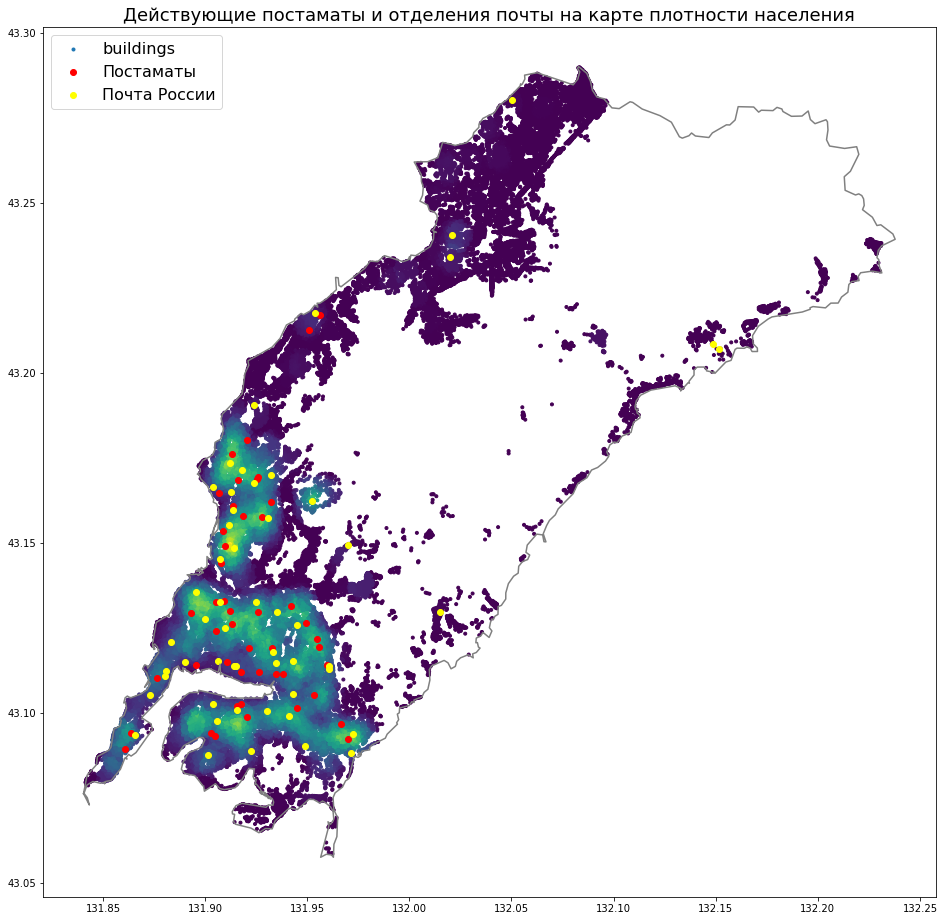

In [73]:
# карта плотности

plt.figure(figsize = (16,16))
plt.plot(boundries[:,0], boundries[:,1], c='grey')

plt.scatter(bui.long, bui.lat, c = bui.density500, cmap = plt.cm.viridis, marker = '.', label = 'buildings')

points = poi[(poi['amenity'] == 'postamat') | (poi['amenity'] == 'pvz')]
plt.scatter(points.long, points.lat, c='red', marker = 'o', label = 'Постаматы')

points = poi[poi['amenity'] == 'post_office']
plt.scatter(points.long, points.lat, c='yellow', marker = 'o', label = 'Почта России')

plt.title('Действующие постаматы и отделения почты на карте плотности населения', fontsize = 18)
plt.legend(fontsize = 16)

In [110]:
pred_ind = cat_model.predict_proba(bui[base_features])[:,1]>0.99
pred_ind.sum()

2150

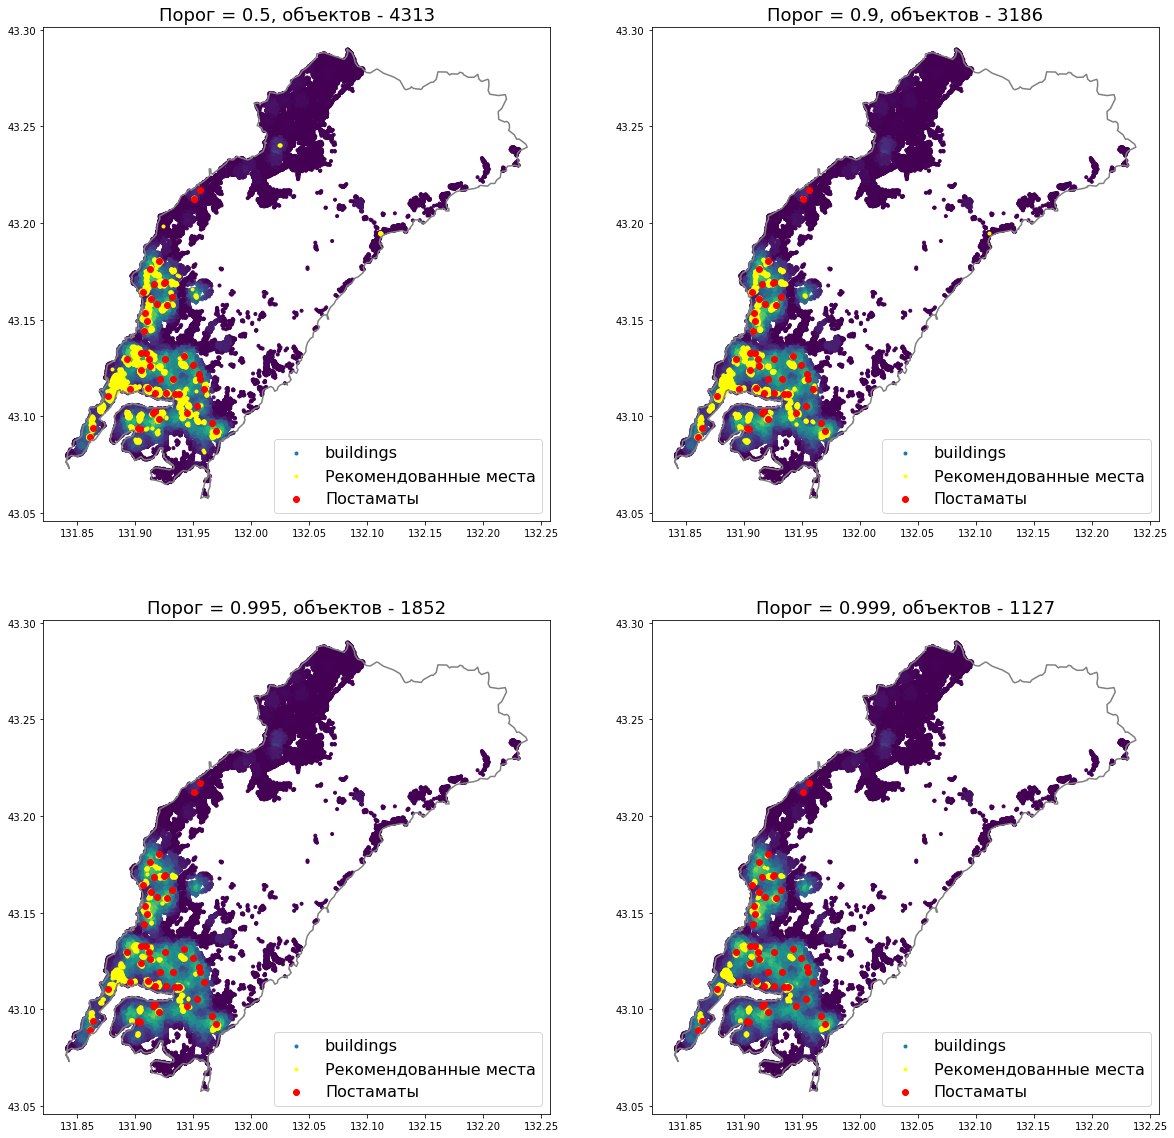

In [78]:
# карта плотности

plt.figure(figsize = (20,20))

for i, trh in enumerate([0.5, 0.9, 0.995, 0.999]):
    plt.subplot(2,2,i+1)
    pred_ind = cat_model.predict_proba(bui[base_features])[:,1]> trh
    objects = pred_ind.sum()

    plt.plot(boundries[:,0], boundries[:,1], c='grey')

    plt.scatter(bui.long, bui.lat, c = bui.density500, cmap = plt.cm.viridis, marker = '.', label = 'buildings')

    points = bui.iloc[pred_ind]
    plt.scatter(points.long, points.lat, c='yellow', marker = '.', label = 'Рекомендованные места')

    points = poi[(poi['amenity'] == 'postamat') | (poi['amenity'] == 'pvz')]
    plt.scatter(points.long, points.lat, c='red', marker = 'o', label = 'Постаматы')

    plt.title('Порог = {}, объектов - {}'.format(trh, objects), fontsize = 18)
    plt.legend(fontsize = 16)

In [80]:
# Визуализируем вероятность размещения в каждой точке, прологарифмировав значения вероятностей
# (это уже не будут вероятности от 0 до 1, но при необходимости можно провести соответствующее преобразование)

proba = np.log(cat_model.predict_proba(bui[base_features])[:,1])


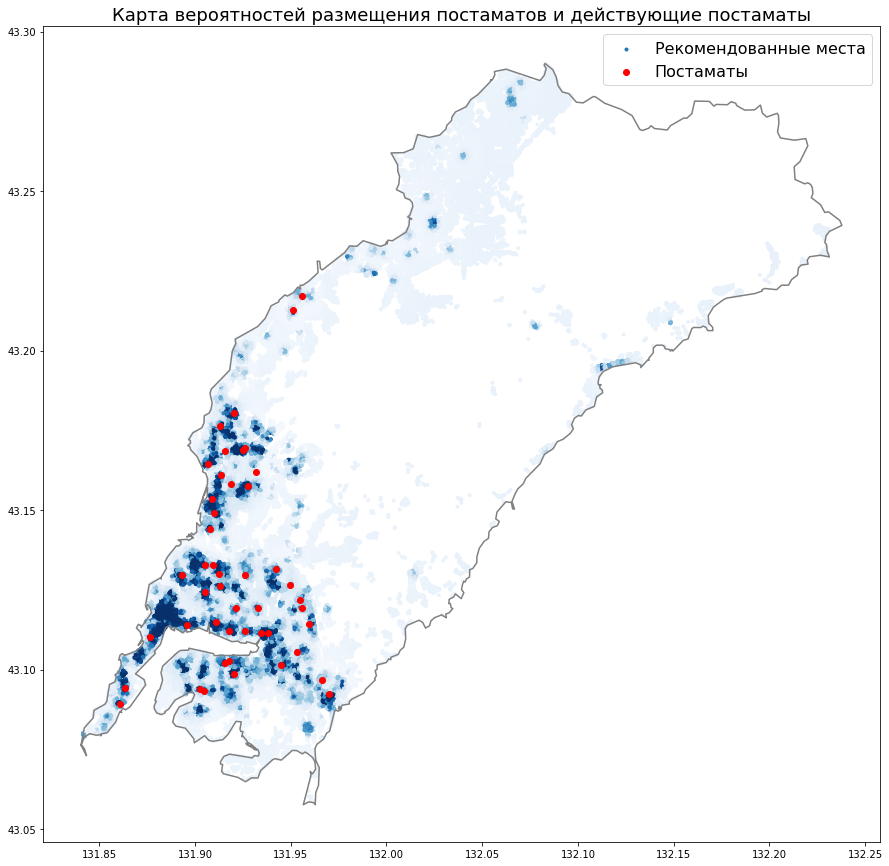

In [81]:
# карта плотности

plt.figure(figsize = (15,15))
plt.plot(boundries[:,0], boundries[:,1], c='grey')

points = bui
plt.scatter(points.long, points.lat, c = proba, cmap = 'Blues', marker = '.', label = 'Рекомендованные места')

points = poi[(poi['amenity'] == 'postamat') | (poi['amenity'] == 'pvz')]
plt.scatter(points.long, points.lat, c='red', marker = 'o', label = 'Постаматы')

plt.title('Карта вероятностей размещения постаматов и действующие постаматы', fontsize = 18)
plt.legend(fontsize = 16)

Мы видим, что модель достаточно хорошо выявляет места нахождения действующих постаматов, 
а также показывает достаточное число локальных экстремумов вероятности, т.е. мест которые
могут быть рассмотрены для размещения постаматов

### Выводы

Построена модель, дающая адекватные первичные прогнозы для размещения постаматов во Владивостоке, исходя из имеющихся в наличии ограниченных данных.

Следующим этапом развития проекта должно быть размещение постаматов в городе и сбор данных по их финансовым и маркетинговым показателям. Эти данные могут быть легко встроены в разработанную модель, а сама модель дообучена.
В этом случае предсказания будут более точны.

Плюсом модели является ее относительная легкость и интерпретируемость